# Structural variations with optical DNA maps

This jupyter notebook works as a framework for a possible supplementary for the future paper on structural variations using optical DNA maps and was written as part of Jupyter Notebooks course https://github.com/mlund/jupyter-course . Notation is used as in the cited papers at the bottom of the notebook.



1. Install [miniconda3](https://conda.io/miniconda.html) alternatively the full
   [anaconda3](https://www.anaconda.com/download) enviroment on your laptop (the latter is **much** larger).
2. [Download](https://github.com/teokem/project-work-2018-albertasdvirnas) this github repository and uzip

3. Navigate to the project folder

4. Run the enviroment yml file 

```bash
conda env create -f dnasvenv.yml
source activate dnasvenv
```

5. Run jupyter notebook


You can reach me at albertas.dvirnas@thep.lu.se for questions
    

In [2]:
import hmmpackage as hm
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.ndimage.filters as fi
import os
import time
from math import floor, exp

# "We use SeqIO to to input file data 
from Bio import SeqIO

import pandas as pd
from ipywidgets import interact, interactive, fixed,widgets



## Simulation of Optical DNA maps

### Known sequence

In the DNA barcoding experiments considered here, DNA is stained with YOYO-1 and netropsin, with a ratio roughly 1:6. DNA is then stretched in nanochannels with dimensions of $100\times 150 \text{nm}^2$ and a length of $500
 \mu$m by using pressure-driven flow created from nitrogen gas. Then $n$ time-frames of the molecule are obtained using EMCCD camera combined with an inverted fluorescence microscope.

If the DNA sequence is known, a mathematical model (in this case a competitive binding model) can be used to simulate the expected output of the experiment. Then a DNA sequence of $k_{\rm max}$ basepairs is converted into a probability vector

\begin{equation} \mathbf p = \{ p(k), k = \overline{0,k_{\max}-1}\},\end{equation}

which gives us the probabilities that a YOYO-1 is bound to a particular
basepair along the DNA. Given this probability vector, $\mathbf p$, a theoretical
barcode is computed as a convolution of $\mathbf p$ with a Gaussian kernel $\boldsymbol{\phi}$ with a width of $\sigma$ bps:

\begin{equation}\boldsymbol{\phi} = \left\{ e^{-\frac{k^2}{2\sigma^2}}, \begin{cases} |k| \leq \lfloor \frac{k_{\rm max}}{2} \rfloor , k_{max} \text{ odd} \\ -\frac{k_{\rm max}}{2}<k \leq \frac{k_{\rm max}}{2}, k_{max} \text{ even}\end{cases}\right\}
\end{equation}

here $\sigma$  regulates how wide the Gaussian is. This convolution is now written according to

\begin{equation}
\tilde{I} (k) = (\mathbf p * \boldsymbol \phi) (k) = \sum_{i=0}^{k_{\rm max}-1}p(i)\cdot \phi(i-k),~ 0 \leq k \leq k_{\rm max}-1 ~
\end{equation}

Finally, the result of this convolution is downsampled to bp/px convertion ratio of the experiment, and saved as $B (k) $ .


To compute the theoretical barcode, we first parse a dna sequence for a fasta file, using the parser from Bio package

In [3]:
filename1 = "data/DA15001-pUUH_Sequence.fasta"

fasta_sequences = SeqIO.parse(open(filename1),'fasta')
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)

Next we compute the probability  vector

In [4]:
plasmid = hm.cb_transfer_matrix_method(sequence)

10.0386300087


We convert this to bp/px ratio of an experiment

In [5]:
filename2 = "data/experiment_sets.txt"
psf, nmbp, nmpx  = np.loadtxt(filename2, delimiter=",", unpack = True)

bar =  hm.seq_to_timeseries(plasmid,len(plasmid),psf/nmbp)

# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
N = int(round(nmpx/nmbp))

averagedbar = pd.Series(bar).rolling(window=N).mean().iloc[N-1:].values
barcode = averagedbar[::N]

# save generated barcode using pandas
df = pd.DataFrame(data=barcode,index=np.arange(1,len(barcode)+1),columns=['barcode']) 
df.to_csv("data/output_data.csv", index=False,sep=',')


And plot the resulting barcode

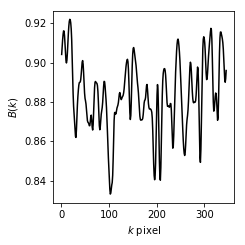

In [6]:
# make the figure of 89mm width and 89mm height. plt accepts inches, so we divide by 2.54
f = plt.figure(figsize=(8.9/2.54,8.9/2.54)) 
ax = plt.axes()
ax.plot(np.arange(1,len(barcode)+1), barcode, color = 'black')
ax.set_xlabel('$k$ pixel')
ax.set_ylabel('$B(k)$')
plt.tight_layout()
plt.savefig('output/figure1.eps',dpi=300)
plt.show()


### Unknown sequence

If underlying DNA sequence is not known, one can simulate random DNA maps using the structure described above. Instead of calculating the probability vector, we generate $k_{\max}$ normally distributed random numbers, and convolve with a Gaussian

In [7]:
def f(x,q):
    seq = np.random.normal(1,1,x);
    vec =  hm.seq_to_timeseries(seq,x,q);
    
    fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(2*8.9/2.54,8.9/2.54))

#     f = plt.figure(figsize=(2*8.9/2.54,8.9/2.54)) 
    (ax1,ax2) = axes
    
    ax1.plot(np.arange(1,len(seq)+1), seq, color = 'black')
    ax1.set_xlabel('$k$ pixel')
    ax1.set_ylabel('barRand$(k)$')
    
    ax2.plot(np.arange(1,len(vec)+1), vec, color = 'black')
    ax2.set_xlabel('$k$ pixel')
    ax2.set_ylabel('rand$(k)$')
    plt.tight_layout()
#     plt.savefig('output/figure2.eps',dpi=300)
    plt.show()
    
    # save generated barcode using pandas
    df = pd.DataFrame(data=seq,index=np.arange(1,len(seq)+1),columns=['barcode']) 
    df.to_csv("output/rand_data.csv", index=False,sep=',')

    df2 = pd.DataFrame(data=vec,index=np.arange(1,len(vec)+1),columns=['barcode']) 
    df2.to_csv("output/rand_vec_without_ins.csv", index=False,sep=',')

barRand1 = interact(f,x=widgets.IntSlider(min=10,max=500,step=1,value=100),q=fixed(psf/nmpx));

A Jupyter Widget

### Structural variation

A third important case of optical maps is when the sequence is known (or is known to be in some database), but there is some structural variation in the data, for example inversion, insertion, translocation or deletion. The goal of this project is to predict such structural variations in both simulated datasets and experimental datasets. 

We use a random sequence generated previously to study such structural variations



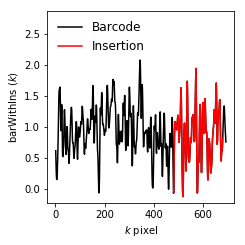

In [14]:
df = pd.read_csv('output/rand_data.csv', sep=',')
df.values;

q = psf/nmpx

insertionLen = 200

def create_random_insertion(df,insertionLen,q): 
    seq = np.random.normal(1,1,insertionLen);
    instertionPlace = np.random.randint(len(df.values))
    
    df2 = pd.DataFrame(data=seq,index=np.arange(instertionPlace+1,instertionPlace+len(seq)+1),columns=['barcode']) 

    df3 = pd.concat([df.loc[:instertionPlace], df2, df.loc[instertionPlace+1:]]).reset_index(drop=True)
    vec =  hm.seq_to_timeseries(df3.values.ravel(),len(df3.values.ravel()),q);
        
    f = plt.figure(figsize=(8.9/2.54,8.9/2.54)) 
    ax = plt.axes()
    
    ax.plot(np.arange(1,len(vec)+1), vec, color = 'black',label = 'Barcode')
    ax.set_xlabel('$k$ pixel')
    ax.set_ylabel('barWithIns $(k)$')
    
    ax.plot(np.arange(instertionPlace+1,instertionPlace+len(seq)+1), vec[np.arange(instertionPlace,instertionPlace+len(seq))], color = 'red',label='Insertion')
    ax.legend(loc='upper left',fontsize=12,frameon=False,markerfirst=True)
    ax.set_ylim([min(vec)-0.1,max(vec)+0.8])
    plt.tight_layout()
    #plt.savefig('output/figure3.eps',dpi=300)
    plt.show()
    
    # save generated barcode using pandas
    df = pd.DataFrame(data=vec,index=np.arange(1,len(vec)+1),columns=['barcode']) 
    df.to_csv("output/rand_vec_with_ins.csv", index=False,sep=',')

    return vec

seqwithinsertion = create_random_insertion(df,insertionLen,q)

## Profile Hidden Markov Model

We want to successfuly identify the structural variations in randomly generated fragments. For this we use a profile hidden Markov model (shortly pHMM) to find the structural variation in the data. This model can be briefly described by the diagram

![](data/msv.png)
In the model we have a number of non-emmiting $(S, B, E,T)$, emmiting states $(N, J, C, M_1,\ldots, M_k)$, and each arrow in the diagram represents a possibility of moving from one state to the next stay. Each such possibility has an associated probability, or cost, for moving from one state to the next. The output of a profile hidden Markov model is a dynamical programming matrix describing the optimal path from the first state $(1,1)$ to the last state $(n,k)$, where the values of the matrix at index $n$, $m$ are the best Viterbi scores of going from $(1,1)$ to $(n,m)$. The associated probabilities then can be trained using supervised machine learning tools (i.e. based on predicted length of structural variations).

We use the random sequences generated in previous section as an example of how this method works. We first load the sequences


In [15]:
df1 = pd.read_csv('output/rand_vec_without_ins.csv', sep=',')
df2 = pd.read_csv('output/rand_vec_with_ins.csv', sep=',')


seq2 = df1.values.ravel()
seq1 = df2.values.ravel()


# seq1 = np.array(y[0]).astype(float)
seq1 = np.reshape(seq1,(-1,len(seq1)))
# seq2 = np.array(y[1]).astype(float)
seq2 = np.reshape(seq2,(-1,len(seq2)))

Next we run an algorithm to compute the Viterbi score

In [16]:
# Compute Viterbi score for this example
vitTraceback, W, score = hm.compute_example(seq1, seq2)

Once the best path is computed, we can store the results in a more convenient table

In [17]:
M = len(seq1[0])
L = len(seq2[0])

resTable = hm.parse_vtrace(vitTraceback, M)

if resTable[-1][1][-1] == resTable[0][1][0]-M+1:
    resTable[0][0].append(resTable[-1][0])
    resTable[0][1].append(resTable[-1][1])
    resTable[-1][0] = []
    resTable[-1][1] = []

Finally we plot the comparison result as a composite plot, with the top image describing the dynamical programming matrix, and the bottom plot displaying the comparison of the two barcodes. 

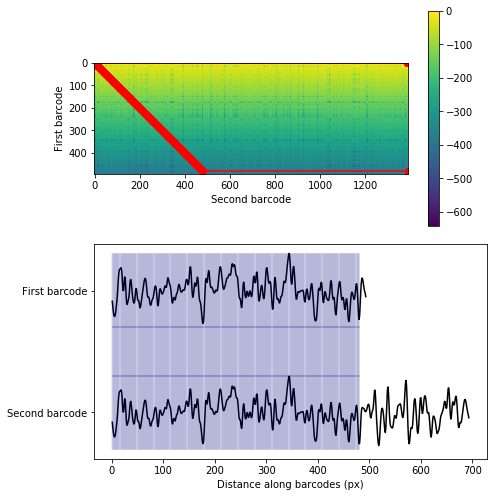

In [22]:
def plot_traceback(vitTraceback, W, M, L,seq1,seq2,resTable):
    index_a, index_b = zip(*vitTraceback)

    fig, axes = plt.subplots(2,1, sharex=False, sharey=False, figsize=(2*8.9/2.54,2*8.9/2.54))
    (ax1,ax2) = axes
    img = ax1.imshow(W, origin='upper', interpolation='none')
    
    plt.colorbar(img, ax=ax1)  # C = M+5
    ax1.plot(index_b, index_a, 'ro-')

    ax1.set_ylabel('First barcode')
    ax1.set_xlabel('Second barcode')
    ax1.set_aspect(1)
    
    bar = st.zscore(seq1[0])
    bar2 = st.zscore(seq2[0])
    ylmax = max(bar)
    ylmin = min(bar)
    yumax = max(bar2 + 10)
    yumin = min(bar2 + 10)

    cmap = plt.get_cmap('jet')
    colors = cmap(np.linspace(0, 1.0, len(resTable)))

    ax2.plot(np.linspace(1,len(bar),len(bar)), bar,'black')

    ax2.plot(np.linspace(1,len(bar2),len(bar2)), bar2 + 10,'black')
    for j in range(0,len(resTable)):

        for i in range(0,len(resTable[j][0])):
            ax2.plot([resTable[j][0][i],resTable[j][0][i]],[13,7],color = colors[j],alpha=0.1)
            ax2.plot([resTable[j][1][i],resTable[j][1][i]],[3,-3],color = colors[j],alpha=0.1)
            ax2.plot([resTable[j][0][i],resTable[j][1][i]],[7,3],color = colors[j],alpha=0.1)

    ax2.set_xlabel('Distance along barcodes (px)')

    ax2.set_yticks([0,10])
    ax2.set_yticklabels(['Second barcode','First barcode'])

    plt.tight_layout()
    #plt.savefig('output/figure4.eps',dpi=300,transparent=True)
    plt.show()
    
plot_traceback(vitTraceback, W, M, L,seq1,seq2,resTable)

(Above) we have a dynamic programming matrix of the comparison. Here every pixel of the first barcode is associated to either a pixel of a second barcode, or to one of the helping states. (Below) we have a graphical cmparison which can be inspected visually. 

## Conclusions

In this project we have shown how to generate theoretical barcodes from DNA sequences, and a method for how to look for structural variations for randomly generated barcodes. In the continuation of the project we are going to look into some real DNA sequences and structural variations in those.  

### References

EDDY, Sean R.. . Profile hidden Markov models. Bioinformatics (Oxford, England), 1998, 14.9: 755-763.

DVIRNAS, Albertas, et al. Facilitated sequence assembly using densely labeled optical DNA barcodes: A combinatorial auction approach. PloS one, 2018, 13.3: e0193900.